In [1]:
# Import libraries

import pandas as pd
import scipy
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.ticker as ticker
import numpy as np
import seaborn as sns
import importlib
import meterUncertainty
import itertools
from scipy import odr
import lxml
# importlib.reload(meterUncertainty)

In [2]:
# Import data, basic data cleanup

satelliteResults = pd.read_csv('/Users/evansherwin/PycharmProjects/SatelliteTesting/Data/matchedDF_Satellites_220601.csv')
satelliteResults['Estimate (KGH) num'] = satelliteResults['FacilityEmissionRate'].apply(pd.to_numeric, errors='coerce')
satelliteResults['Error num'] = (satelliteResults['Estimate (KGH) num'] - satelliteResults['cr_kgh_CH4_mean300'])*100/satelliteResults['cr_kgh_CH4_mean300']
satelliteResults['Wind speed est num'] = satelliteResults['WindSpeed'].apply(pd.to_numeric, errors='coerce')
# satelliteResults['Estimate in situ wind (KGH) num'] = satelliteResults['ISWind FacilityEmissionRate'].apply(pd.to_numeric, errors='coerce')
# satelliteResults['Error in situ wind num'] = satelliteResults['Error in situ wind'].apply(pd.to_numeric, errors='coerce')*100
# satelliteResults.head()
satelliteResults

,Unnamed: 0,level_0,index,PerformerExperimentID,FacilityID,EquipmentUnitID,DateOfSurvey,Operator_Timestamp,StartTime,EndTime,...,cr_kgh_CH4_upper300,cr_kgh_CH4_mean600,cr_kgh_CH4_lower600,cr_kgh_CH4_upper600,cr_kgh_CH4_mean900,cr_kgh_CH4_lower900,cr_kgh_CH4_upper900,Estimate (KGH) num,Error num,Wind speed est num
0,0,1672,NaN,1.0,1.0,1.0,NaN,2021-10-16 17:26:40+00:00,NaN,NaN,...,1779.495469,1697.119999,1553.816116,1864.022376,1686.851597,1495.228521,1888.052860,1382.0,-17.140810,3.720000
1,1,1724,NaN,1.0,1.0,1.0,NaN,2021-10-16 17:26:40+00:00,NaN,NaN,...,1773.164358,1694.356406,1544.091848,1826.400549,1664.343187,1493.249938,1876.415357,1534.0,-8.209268,4.270000
2,2,1673,NaN,2.0,1.0,1.0,NaN,2021-10-24 17:35:19+00:00,NaN,NaN,...,4484.857808,4238.145503,4002.961571,4487.774311,4216.022530,3990.286746,4465.095937,3848.0,-8.889579,2.010000
3,3,1725,NaN,2.0,1.0,1.0,NaN,2021-10-24 17:35:19+00:00,NaN,NaN,...,4498.291022,4229.551134,4002.861846,4456.075687,4210.302115,3989.505816,4441.528761,4408.0,4.051805,2.490000
4,4,1674,NaN,3.0,1.0,1.0,NaN,2021-10-25 17:24:37+00:00,NaN,NaN,...,208.631220,198.448135,187.738648,210.096073,147.709664,140.086366,156.236479,223.0,12.992303,5.060000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,83,1775,NaN,48.0,NaN,NaN,NaN,2021-11-03 18:25:01+00:00,NaN,NaN,...,1460.175444,1400.864644,1319.854699,1477.249663,1265.086694,1201.493490,1331.607519,0.0,-100.000000,0.000000
84,84,1690,NaN,16.0,NaN,NaN,NaN,2021-10-23 18:40:53+00:00,NaN,NaN,...,4180.538944,4012.906091,3814.234600,4247.224919,4011.045702,3808.841204,4229.398984,4069.0,2.936855,3.771273
85,85,1705,NaN,30.0,1.0,1.0,NaN,2021-10-23 18:40:53+00:00,NaN,NaN,...,4187.135793,4020.250944,3808.753978,4260.245988,4018.420708,3829.280479,4251.379848,1282.0,-67.603800,2.900000
86,86,1742,NaN,16.0,NaN,NaN,NaN,2021-10-23 18:40:53+00:00,NaN,NaN,...,4189.653403,4011.644618,3806.757670,4224.039595,4009.838172,3797.734234,4217.441557,4790.0,21.265665,4.673417


In [3]:
# Reorder satellite and team factor levels

satelliteNames = np.unique(satelliteResults['Satellite'])[[0, 2, 3, 1, 4]] # Reorder satellite names to match factor levels
numSatellites = satelliteNames.size
satelliteResults['SatelliteNum'] = pd.factorize(satelliteResults['Satellite'])[0] + 1
teamNames = np.unique(satelliteResults['Team'])[[0, 4, 2, 1, 3]] # Reorder team names to match factor levels
numTeams = teamNames.size
satelliteResults['teamNum'] = pd.factorize(satelliteResults['Team'])[0] + 1

In [4]:
# Generate errorbars

yCImult = 1 # 1 #1.96 # Multiplier of standard deviation for 95% confidence interval.
xCImult = yCImult/1.96 # When converting 95% CI in the x-axis to 1-sigma, multiply by this (will be 1 if y-axis uses 95% CI)

satelliteResults['Est sdev'] = 0
satelliteResults.loc[satelliteResults['UncertaintyTypeManual']=='UT 1 sigma', 'Est sdev'] = satelliteResults.loc[satelliteResults['UncertaintyTypeManual']=='UT 1 sigma', 'UncertaintyType'].apply(pd.to_numeric, errors='coerce')
satelliteResults.loc[satelliteResults['UncertaintyTypeManual']=='+/- 1 sigma', 'Est sdev'] = np.subtract(satelliteResults.loc[satelliteResults['UncertaintyTypeManual']=='+/- 1 sigma', 'FacilityEmissionRate'].apply(pd.to_numeric, errors='coerce'),
                                                                                              satelliteResults.loc[satelliteResults['UncertaintyTypeManual']=='+/- 1 sigma', 'FacilityEmissionRateLower'].apply(pd.to_numeric, errors='coerce'))
satelliteResults['Flux est CI low'] = satelliteResults['Estimate (KGH) num'] - satelliteResults['Est sdev']*yCImult
satelliteResults['Flux est CI high'] = satelliteResults['Estimate (KGH) num'] + satelliteResults['Est sdev']*yCImult
# SRON put switched the high and low confidence intervals in their reported sheet
satelliteResults.loc[satelliteResults['UncertaintyTypeManual']=='Min/max', 'Flux est CI low'] = \
    satelliteResults['Estimate (KGH) num'] - (satelliteResults['Estimate (KGH) num'] -
                                              satelliteResults.loc[satelliteResults['UncertaintyTypeManual']=='Min/max', 'FacilityEmissionRateUpper'].apply(pd.to_numeric, errors='coerce')
                                              )*yCImult
satelliteResults.loc[satelliteResults['UncertaintyTypeManual']=='Min/max', 'Flux est CI high'] = \
    satelliteResults['Estimate (KGH) num'] - (satelliteResults['Estimate (KGH) num'] -
                                              satelliteResults.loc[satelliteResults['UncertaintyTypeManual']=='Min/max', 'FacilityEmissionRateLower'].apply(pd.to_numeric, errors='coerce')
                                              )*yCImult
satelliteResults['within CI'] = (satelliteResults['Flux est CI low']  < satelliteResults['cr_kgh_CH4_mean300']) & (satelliteResults['Flux est CI high'] > satelliteResults['cr_kgh_CH4_mean300']) & (satelliteResults['cr_kgh_CH4_mean300'] > 0)
# satelliteResults['Flux est CI low']

# Generate x errors
satelliteResults['x95pctCILower'] = np.abs(satelliteResults['cr_kgh_CH4_lower300'] - satelliteResults['cr_kgh_CH4_mean300'])
satelliteResults['x95pctCIUpper'] = np.abs(satelliteResults['cr_kgh_CH4_upper300'] - satelliteResults['cr_kgh_CH4_mean300'])

In [5]:
# Set color palette
colors = np.array(['#C74632', '#D1660F', '#007C92', '#7F7776', '#734675'])
colorsForErrorbars = np.array(['#C74632', '#7F7776', '#D1660F', '#007C92', '#734675'])
markers = np.array(['o', 'X', 's', 'P', 'd'])
# Set your custom color palette
StanfordPalette = sns.set_palette(sns.color_palette(colors))
# StanfordPalette = sns.color_palette(colors)
# Update font
# plt.rcParams.update({'font.family':'sans-serif'})
# plt.rcParams.update({'font.sans-serif':'Helvetica'})
# plt.rcParams.update({'font.family':'serif'})
# plt.rcParams.update({'font.serif':'Palatino'})

# rc('font',**{'family':'serif','serif':['Palatino']})
# plt.rcParams['pdf.fonttype'] = 42

StanfordPalette

<Figure size 432x288 with 0 Axes>

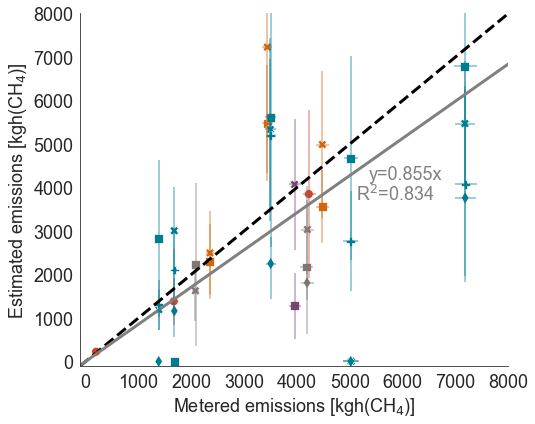

In [9]:
# ax = plt.gca()
fig = plt.gcf()
#fig.set_size_inches(100, 8)

unblindingStage = 1 # 1 # 2
selectedSatelliteResults = satelliteResults[satelliteResults['UnblindingStage']==unblindingStage]
# selectedSatellite = 'WV3' # 'PRISMA' # 'GHGSat C2' # 'Landsat 8' 'Sentinel-2' 'WV3'
# selectedSatelliteResults = satelliteResults[(satelliteResults['UnblindingStage']==unblindingStage) & (satelliteResults['Satellite']==selectedSatellite)]
# selectedTeam =  'Kayrros'# 'SRON' # 'Harvard' # 'UPV'# 'GHGSat'# 'Kayrros'
# selectedSatelliteResults = satelliteResults[(satelliteResults['UnblindingStage']==unblindingStage) & (satelliteResults['Team']==selectedTeam)]
selectedSatelliteNames = np.unique(selectedSatelliteResults['Satellite'])
selectedSatellitePos = np.in1d(satelliteNames, selectedSatelliteNames) #np.where(satelliteNames == selectedSatellite)[0][0] - 1
selectedSatelliteNames = selectedSatelliteNames.tolist()
selectedTeamNames = np.unique(selectedSatelliteResults['Team'])
teamPos = np.in1d(teamNames, selectedTeamNames)
slctColors = colors[selectedSatellitePos]
StanfordPalette = sns.set_palette(sns.color_palette(slctColors))

# For main plots, UPV, and Kayrros
slctColorsForErrorbars = colorsForErrorbars[selectedSatellitePos] # np.append(slctColors[1:], slctColors[0])# slctColors# np.append(slctColors[1:], slctColors[0])  # colorsForErrorbars[selectedSatellitePos]
# For individual satellites and teams
# slctColorsForErrorbars = np.append(slctColors[1:], slctColors[0])# slctColors# np.append(slctColors[1:], slctColors[0])

slctMarkers = markers[teamPos].tolist()

# mainScatterPlot = sns.relplot(data=selectedSatelliteResults, x='cr_kgh_CH4_mean300', y='Estimate (KGH) num', style='Team', hue='Satellite', s=80, kind='scatter', height=6, aspect=1.05) #, legend=False) # 'logged KGH', palette='tab10'
mainScatterPlot = sns.relplot(data=selectedSatelliteResults, x='cr_kgh_CH4_mean300', y='Estimate (KGH) num', style='Team', hue='Satellite', markers=slctMarkers, s=80, kind='scatter', height=6, aspect=1.05) #, legend=False) # 'logged KGH', palette='tab10'
# mainScatterPlot = sns.relplot(data=selectedSatelliteResults, x='cr_kgh_CH4_mean300', y='Estimate (KGH) num', style='Team', hue='Satellite', markers=slctMarkers, s=80, kind='scatter', height=6, aspect=1.05) #, legend=False) # 'logged KGH', palette='tab10'
# In situ wind
# mainScatterPlot = sns.relplot(data=satelliteResults[satelliteResults['UnblindingStage']==2], x='cr_kgh_CH4_mean300', y='Estimate (KGH) num', style='Team', hue='Satellite', s=80, kind='scatter', height=6, aspect=1.05) #, legend=False) # 'logged KGH', palette='tab10'
lims = [-100, 8000]
plt.plot(lims, lims, '--', color='black', linewidth=3)
sns.move_legend(mainScatterPlot, 'upper left', bbox_to_anchor=(0.14, 0.99))
# plt.errorbar(x=satelliteResults['Estimate (kgh) mean'], y=satelliteResults['Estimate (KGH) num'], xerr=meteredErrorbarsFlat, yerr=satelliteResults['Estimate (KGH) num']*0.1, fmt='.')
# satelliteResults['Estimate (kgh) P97_5'] - satelliteResults['Estimate (kgh) mean']
# sns.set_style("white")
# plt.axhline(1000, ls='--', linewidth=3, color='red')
# plt.plot([0,0], [8000,8000])
# mainScatterPlot.ax_joint.plot([0,0], [8000,8000], '-', linewidth = 2)

plt.xlim(-100,8000) #10000
plt.ylim(-100,8000) #10000
# mainScatterPlot._legend.set_title("Satellite")
# mainScatterPlot._legend.set_title(None)
mainScatterPlot._legend.remove()

# Comment out to remove legend
# plt.legend(bbox_to_anchor=(0.01, 1), loc='upper left', borderaxespad=0, fontsize=12)#, title_fontsize= 'large')

# plt.legend(fontsize= 60)
# mainScatterPlot._legend.draw_frame(True)
mainScatterPlot._legend.set_frame_on(True)
plt.xlabel('Metered emissions [kgh(CH$_4$)]', fontsize=18)
plt.ylabel('Estimated emissions [kgh(CH$_4$)]', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

colorCounter = 0
# shapes = itertools.cycle(['o', 'x', 's', '+', 'd'])
for satellite in selectedSatelliteNames:
    selectedData = selectedSatelliteResults.loc[(selectedSatelliteResults['Satellite'] == satellite)]
    slctMeteredErrorbars = selectedData[['cr_kgh_CH4_lower300', 'cr_kgh_CH4_upper300']].sub(selectedData['cr_kgh_CH4_mean300'], axis='index')
    slctMeteredErrorbarsFlat = np.concatenate(np.array(slctMeteredErrorbars)).reshape(len(slctMeteredErrorbars), 2).transpose()
    # selectedErrors = satelliteResults.loc[(satelliteResults['Satellite'] == satellite)]
    slctColor = slctColorsForErrorbars[colorCounter]
    # plt.errorbar(selectedData['Estimate (kgh) mean'],
    #             selectedData['Estimate (KGH) num'], xerr=slctMeteredErrorbarsFlat, yerr=selectedData['Estimate (KGH) num']*0.1, fmt='.', color=slctColor)
    plt.errorbar(selectedData['cr_kgh_CH4_mean300'], selectedData['Estimate (KGH) num'],
                 xerr=np.array([selectedData['x95pctCILower']*xCImult, #*xCImult
                                selectedData['x95pctCIUpper']*xCImult]), #*xCImult
                 # xerr=np.array([np.abs(selectedData['cr_kgh_CH4_lower300'] -
                 #                       selectedData['cr_kgh_CH4_mean300']), #*xCImult
                 #                np.abs(selectedData['cr_kgh_CH4_upper300'] -
                 #                       selectedData['cr_kgh_CH4_mean300'])]), #*xCImult
                 yerr=np.array([np.abs(selectedData['Flux est CI low'] -
                                       selectedData['Estimate (KGH) num']),
                                np.abs(selectedData['Flux est CI high'] -
                                       selectedData['Estimate (KGH) num'])]), fmt='.', color=slctColor, alpha=0.5)
    colorCounter = colorCounter + 1

# plt.rcParams["figure.figsize"] = (6,5)
#sns.set(rc={"figure.figsize":(10, 5)})
sns.set_style("white") # "whitegrid

# Linear regression for satellite data, forced zero intercept
regData = selectedSatelliteResults.loc[(satelliteResults['Estimate (KGH) num'] > 0), ['cr_kgh_CH4_mean300', 'Estimate (KGH) num']]
regData.columns = ['x', 'y']
model = smf.ols(formula="y ~ x + 0", data=regData)
# model = smf.ols(formula="y ~ x", data=regData)
result = model.fit()
# result.summary()
results_as_html_main = result.summary().tables[1].as_html()
results_as_html_r2 = result.summary().tables[0].as_html()
# results_as_html
results_main = pd.read_html(results_as_html_main, header=0, index_col=0)[0]
results_r2_and_more = pd.read_html(results_as_html_r2, header=0, index_col=0)[0]
results_r2 = results_r2_and_more.columns[2]
results_coeff = results_main['coef'][0]

x_domain = np.array([lims[0], lims[1]]).reshape(-1,1)
y_pred = x_domain*results_coeff

plt.plot(x_domain, y_pred, '-', color='gray', linewidth=3)
plt.text(6750, 4200, 'y='+str(np.round(results_coeff, 3))+'x', fontsize=18, color='gray', rotation=0, ha='right') # -63
plt.text(6600, 3700, 'R$^2$='+results_r2, fontsize=18, color='gray', rotation=0, ha='right') # -63
# For in situ wind case
# plt.text(6750, 5000, 'y='+str(np.round(results_coeff, 3))+'x', fontsize=18, color='gray', rotation=0, ha='right') # -63
# plt.text(6600, 4500, 'R$^2$='+results_r2, fontsize=18, color='gray', rotation=0, ha='right') # -63

# Add border around plot
# https://stackoverflow.com/questions/2027592/draw-a-border-around-subplots-in-matplotlib
# rect = plt.Rectangle(
#     # (lower-left corner), width, height
#     (0.02, 0.5), 5000, 5000, fill=True, color="k", lw=2,
#     zorder=1000, transform=fig.transFigure, figure=fig
# )
# fig.patches.extend([rect])

# mainScatterPlot.despine(left=True, bottom=True)
# ax.get_yaxis().set_major_formatter(
#     ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
# ax.get_xaxis().set_major_formatter(
#     ticker.FuncFormatter(lambda x, p: format(int(x), ',')))# sns.set_style('darkgrid', {'legend.frameon':True})
# mainScatterPlot.legend().set_framecolor('black')
# ax.get_yaxis().set_major_formatter(
#     ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
# ax.get_xaxis().set_major_formatter(
#     ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.tight_layout()
plt.savefig('Satellite parity 20220628c.pdf', format='pdf')
# plt.savefig('Satellite parity 95CI 20220601.pdf', format='pdf')
# plt.savefig('Satellite parity in situ 20220628b.pdf', format='pdf')
# plt.savefig('Satellite parity in situ 95CI 20220601.pdf', format='pdf')
# plt.savefig('Satellite parity 600s 20220310.pdf', format='pdf')
# plt.savefig('Satellite parity Sentinel-2 20220601.pdf', format='pdf')
# plt.savefig('Satellite parity Landsat 8 20220601.pdf', format='pdf')
# plt.savefig('Satellite parity GHGSat 20220601.pdf', format='pdf')
# plt.savefig('Satellite parity PRISMA 20220601.pdf', format='pdf')
# plt.savefig('Satellite parity WorldView 3 20220601.pdf', format='pdf')
# plt.savefig('Satellite parity Kayrros 20220601.pdf', format='pdf')
# plt.savefig('Satellite parity UP Valencia 20220601.pdf', format='pdf')
# plt.savefig('Satellite parity Harvard 20220601.pdf', format='pdf')
# plt.savefig('Satellite parity SRON 20220601.pdf', format='pdf')
plt.show()

In [24]:
# 95% confidence interval for the linear fit
coeffp95 = results_coeff + 1.96*results_main['std err']
coeffp05 = results_coeff - 1.96*results_main['std err']
coeffp05, coeffp95

(x    0.71976
 Name: std err, dtype: float64,
 x    0.99024
 Name: std err, dtype: float64)

In [40]:
# Regression summary
result.summary()
# results_main

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.911
Model:                            OLS   Adj. R-squared (uncentered):              0.908
Method:                 Least Squares   F-statistic:                              315.4
Date:                Fri, 10 Jun 2022   Prob (F-statistic):                    8.39e-18
Time:                        07:50:30   Log-Likelihood:                         -273.68
No. Observations:                  32   AIC:                                      549.4
Df Residuals:                      31   BIC:                                      550.8
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x              1.0043      0.057     17.761      0.000       0.889       1.120
==============================================================================
Omnibus:                        1.104   Durbin-Watson:                   1.241
Prob(Omnibus):                  0.576   Jarque-Bera (JB):                1.059
Skew:                          -0.394   Prob(JB):                        0.589
Kurtosis:                       2.582   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [34]:
# Regression R2 and more summary
result.summary().tables[1]
# results_r2_and_more


,coef,std err,t,P>|t|,[0.025,0.975]
x,1.0043,0.057,17.761,0.000,0.889,1.120


In [26]:
# Linear regression for satellite data, forced zero intercept
include_intercept=False # True False
X = np.array(selectedSatelliteResults.loc[(satelliteResults['Estimate (KGH) num'] > 0), 'cr_kgh_CH4_mean300']).reshape(-1,1)
y = np.array(selectedSatelliteResults.loc[(satelliteResults['Estimate (KGH) num'] > 0), 'Estimate (KGH) num']).reshape(-1,1)
reg = LinearRegression(fit_intercept=include_intercept).fit(X, y)
reg.coef_, reg.intercept_, reg.score(X, y)
# x_domain = np.array([lims[0], lims[1]]).reshape(-1,1)
# y_pred = reg.predict(x_domain)

(array([[1.00433679]]), 0.0, 0.5056427904498827)

In [144]:
# Model II regression/ODR
# From Yuanlei Chen
def f(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]

def f_zero_intercept(B,x):
    return np.multiply(B,x)

def odr_results(x,y,force_intercept_origin=False):

    """
Regression to output all values to be potentially used in plotting:
n = number of points in scatter plot;
slope, intercept = regression coefficients;
x_lim = (min&max) of x;
y_pred = (min&max) of y_predction computed with slope, intercept, and x_lim;
lower_CI, upper_CI are bounds of 95% confidence interval for the fit line;
lower_PI, upper_CI are bounds of 95% prediction interval for predictions
residual = y – y_pred
see reference: http://www2.stat.duke.edu/~tjl13/s101/slides/unit6lec3H.pdf
Code derived from: https://docs.scipy.org/doc/scipy/reference/odr.html
    """

    n = len(x)
    wd = 1./np.power(np.std(x),2)
    we = 1./np.power(np.std(y),2)
    data = odr.Data(x, y, wd, we)

    # ODR regression
    if force_intercept_origin==False:
        linear = odr.Model(f)
        odr_model = odr.ODR(data, linear, beta0=[1., 0.])   # give an initial guess of the coefficients
        output = odr_model.run()
    elif force_intercept_origin==True:
        linear = odr.Model(f_zero_intercept)
        odr_model = odr.ODR(data, linear, beta0=[1.])
        output = odr_model.run()

    # assign coefficients
    slope = output.beta[0]
    if force_intercept_origin==False:
        intercept = output.beta[1]
    elif force_intercept_origin==True:
        intercept = 0

    # compute residuals and predictions
    x_lim = np.array([0,max(x)])
    y_pred = slope*x + intercept
    residual = y - y_pred
    dof = n - 2                               # degree of freedom is n-2 for model 2 regression
    t_score = stats.t.ppf(1-0.025, df=dof)    # one-sided t-test

    # sort x from smallest to largest for ease of plotting
    df = pd.DataFrame()
    df['x'] = x
    df['y'] = y
    df = df.sort_values('x')
    x = df.x.values
    y = df.y.values

    y_hat = slope*x+intercept
    x_mean = np.mean(x)
    S_yy = np.sum(np.power(y-y_hat,2))      # total sum of error in y
    S_xx = np.sum(np.power(x-x_mean,2))     # total sum of variation in x

    # find lower and upper bounds of CI and PI
    lower_CI = y_hat - t_score * np.sqrt(S_yy/dof * (1/n+np.power(x-x_mean,2)/S_xx))
    upper_CI = y_hat + t_score * np.sqrt(S_yy/dof * (1/n+np.power(x-x_mean,2)/S_xx))
    lower_PI = y_hat - t_score * np.sqrt(S_yy/dof * (1/n+1+np.power(x-x_mean,2)/S_xx))
    upper_PI = y_hat + t_score * np.sqrt(S_yy/dof * (1/n+1+np.power(x-x_mean,2)/S_xx))

    return n,slope,intercept,x_lim,y_pred,lower_CI,upper_CI,lower_PI,upper_PI,residual

In [190]:
pearson_corr, _ = stats.pearsonr((reg.coef_*X + reg.intercept_).flatten(), y.flatten())
pearson_corr
# reg = sm.OLS(fit_intercept=include_intercept).fit(X, y)
# reg.bse
# .reshape(-1,1)
# n,pearson_corr,slope,intercept,r_value,x_lim,y_pred,lower_CI,upper_CI,lower_PI,upper_PI,residual,std_err = linreg_results_no_intercept(selectedSatelliteResults.loc[(satelliteResults['Estimate (KGH) num'] > 0), 'cr_kgh_CH4_mean300'], selectedSatelliteResults.loc[(satelliteResults['Estimate (KGH) num'] > 0), 'Estimate (KGH) num'])
# slope,intercept,r_value



0.7695666035407926

In [13]:
# Linear regression for satellite data, forced zero intercept
include_intercept=True # True
force_intercept=include_intercept==False
n,slope,intercept,x_lim,y_pred,lower_CI,upper_CI,lower_PI,upper_PI,residual = odr_results(X.flatten(), y.flatten(), force_intercept_origin=force_intercept)
# n,slope,intercept,x_lim,y_pred,lower_CI,upper_CI,lower_PI,upper_PI,residual
slope, intercept

NameError: name 'odr_results' is not defined

In [191]:
# ODR Pearson correlation
pearson_corrODR, _ = stats.pearsonr((slope*X + intercept).flatten(), y.flatten())
pearson_corrODR



0.7695666035407926

In [14]:
# Test based on my own data
# From https://docs.scipy.org/doc/scipy/reference/odr.html
wd = 1./np.power(np.std(X),2)
we = 1./np.power(np.std(y),2)
data = odr.Data(X, y, wd, we)
linear =  odr.Model(f)
odr_model = odr.ODR(data, linear, beta0=[1., 2.])
output = odr_model.run()
output.beta

NameError: name 'f' is not defined

In [105]:
# df = pd.DataFrame()
# df['x'] = X
# df
X.flatten()

array([1669.22685853, 4232.38251573,  197.31426163, 2349.11126448,
       2349.55685661, 4477.17883283, 4465.01520806, 3430.82244104,
       3445.2559468 , 7174.88184435, 7168.46295983, 7175.51709201,
       7172.04840487, 4183.67659157, 4194.5150315 , 4172.90264425,
       1676.19626416, 1674.55510666, 1678.19833932, 3504.2627911 ,
       3498.01324347, 3485.99341642, 3488.91448657, 2080.91462062,
       2079.21415478, 5023.62145576, 5024.9009625 , 1386.19357658,
       1387.5237241 , 1386.3126786 , 3957.95229625, 3953.37974119])

In [53]:
# Error statistics by team
unblindingStage = 2 # 1 # 2
# Select satellite results for the correct unblinding stage, excluding non-detects
selectedSatelliteResults = satelliteResults[(satelliteResults['UnblindingStage']==unblindingStage) & (satelliteResults['Error num'] > -100)]
# x='cr_kgh_CH4_mean300', y='Estimate (KGH) num' 'Error num'
selectedSatelliteResults.groupby('Team')['Error num'].agg(['count', 'min', 'mean', 'max', 'std'])

,count,min,mean,max,std
Team,,,,,
GHGSat,3,-8.209268,7.946916,27.998210,18.415327
Harvard,5,-20.891947,17.670868,58.272634,31.159059
Kayrros,10,-60.065091,24.175877,130.784948,51.991917
SRON,4,-34.762921,-27.599653,-10.278976,11.611290
UPV,10,-16.364877,26.181968,65.477440,31.105193


In [51]:
# Error statistics by satellite
selectedSatelliteResults.groupby('Satellite')['Error num'].agg(['count', 'min', 'mean', 'max', 'std'])


,count,min,mean,max,std
Satellite,,,,,
GHGSat C2,3,-8.209268,7.946916,27.998210,18.415327
Landsat 8,5,-33.561941,-11.055090,19.878627,20.607909
PRISMA,6,6.854812,44.498127,64.470808,20.414444
Sentinel-2,16,-34.762921,19.288769,130.784948,43.470432
WV3,2,-60.065091,-19.399713,21.265665,57.509529


/Users/evansherwin/PycharmProjects/SatelliteTesting/venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


<Figure size 432x288 with 0 Axes>

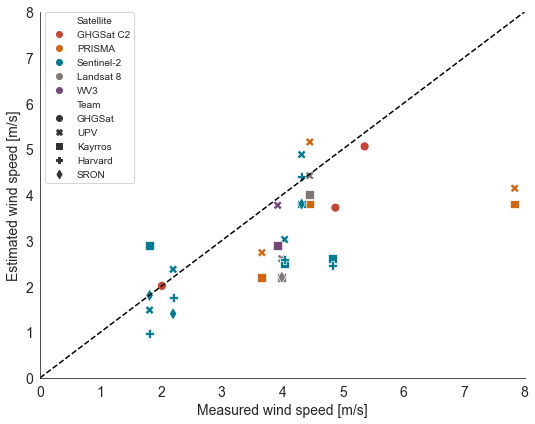

In [38]:
# Wind speed parity chart

fig = plt.gcf()
#fig.set_size_inches(100, 8)

unblindingStage = 1 # 1 # 2
# selectedSatelliteResults = satelliteResults[satelliteResults['UnblindingStage']==unblindingStage]
StanfordPalette = sns.set_palette(sns.color_palette(slctColors))
slctMarkers = markers[teamPos].tolist()

mainScatterPlot = sns.relplot(data=selectedSatelliteResults[(satelliteResults['UnblindingStage']==unblindingStage) & (satelliteResults['Error num'] > -100)], x='Wind_MPS_mean60', y='Wind speed est num', style='Team', hue='Satellite', markers=slctMarkers, s=80, kind='scatter', height=6, aspect=1.05)

lims = [0, 8]
plt.plot(lims, lims, '--', color='black')
sns.move_legend(mainScatterPlot, 'upper left', bbox_to_anchor=(0.14, 0.99))


plt.xlim(lims[0],lims[1]) #10000
plt.ylim(lims[0],lims[1]) #10000
mainScatterPlot._legend.remove()
plt.legend(bbox_to_anchor=(0.01, 1), loc='upper left', borderaxespad=0)#, title_fontsize= 'large')
mainScatterPlot._legend.set_frame_on(True)
plt.xlabel('Measured wind speed [m/s]', fontsize=14)
plt.ylabel('Estimated wind speed [m/s]', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

sns.set_style("white") # "whitegrid
plt.tight_layout()
plt.savefig('Satellite wind parity 20220601b.pdf', format='pdf')
plt.show()



In [83]:
nonzeroRetrievals = satelliteResults.loc[(satelliteResults['Estimate (KGH) num'] > 0) & (satelliteResults['UnblindingStage']==unblindingStage)].shape[0]
nonzeroWithinCI = satelliteResults.loc[satelliteResults['within CI'] & (satelliteResults['UnblindingStage']==unblindingStage)].shape[0]
nonzeroWithinCI/nonzeroRetrievals
# nonzeroWithinCI
# nonzeroRetrievals

0.90625

In [84]:
nonzeroRetrievalsBySatelliteTeam = satelliteResults.loc[(satelliteResults['Estimate (KGH) num'] > 0) & (satelliteResults['UnblindingStage']==unblindingStage)].groupby('OperatorSet').size()
nonzeroWithinCIBySatelliteTeam = satelliteResults.loc[satelliteResults['within CI'] & (satelliteResults['UnblindingStage']==unblindingStage)].groupby('OperatorSet').size()
nonzeroWithinCIBySatelliteTeam/nonzeroRetrievalsBySatelliteTeam
# nonzeroWithinCI
# nonzeroRetrievalsBySatellite

OperatorSet
GHGSat C2/GHGSat      1.000000
Landsat 8/Kayrros     1.000000
Landsat 8/SRON             NaN
Landsat 8/UPV         1.000000
PRISMA/Kayrros        1.000000
PRISMA/UPV            1.000000
Sentinel-2/Harvard    1.000000
Sentinel-2/Kayrros    1.000000
Sentinel-2/SRON       0.666667
Sentinel-2/UPV        1.000000
WV3/Kayrros                NaN
WV3/UPV               1.000000
dtype: float64

In [225]:
nonzeroRetrievalsBySatellite = satelliteResults.loc[(satelliteResults['Estimate (KGH) num'] > 0) & (satelliteResults['UnblindingStage']==unblindingStage)].groupby('Satellite').size()
nonzeroWithinCIBySatellite = satelliteResults.loc[satelliteResults['within CI'] & (satelliteResults['UnblindingStage']==unblindingStage)].groupby('Satellite').size()
nonzeroWithinCIBySatellite/nonzeroRetrievalsBySatellite

Satellite
GHGSat C2     1.000000
Landsat 8     0.400000
PRISMA        0.250000
Sentinel-2    0.533333
WV3           0.500000
dtype: float64

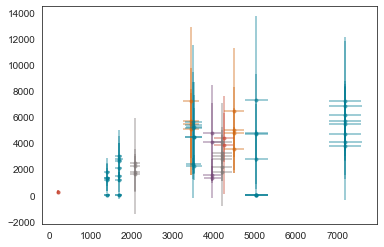

In [88]:
# customParity = plt.scatter(satelliteResults['Estimate (kgh) mean'], satelliteResults['Estimate (KGH) num'], s=10, c='b', marker=satelliteResults['Team'], label='first')

# https://stackoverflow.com/questions/12236566/setting-different-color-for-each-series-in-scatter-plot-on-matplotlib
# Blue, orange, brown, red, purple
colorsIter = itertools.cycle(colors)
# shapes = itertools.cycle(['o', 'x', 's', '+', 'd'])
for satellite in satelliteNames:
    selectedData = satelliteResults.loc[(satelliteResults['Satellite'] == satellite)]
    slctMeteredErrorbars = selectedData[['Estimate (kgh) P2_5', 'Estimate (kgh) P97_5']].sub(selectedData['Estimate (kgh) mean'], axis='index')
    slctMeteredErrorbarsFlat = np.concatenate(np.array(slctMeteredErrorbars)).reshape(len(slctMeteredErrorbars), 2).transpose()
    # selectedErrors = satelliteResults.loc[(satelliteResults['Satellite'] == satellite)]
    slctColor = next(colorsIter)
    # plt.errorbar(selectedData['Estimate (kgh) mean'],
    #             selectedData['Estimate (KGH) num'], xerr=slctMeteredErrorbarsFlat, yerr=selectedData['Estimate (KGH) num']*0.1, fmt='.', color=slctColor)
    plt.errorbar(selectedData['Estimate (kgh) mean'], selectedData['Estimate (KGH) num'],
                 xerr=np.array([np.abs(selectedData['Estimate (kgh) P2_5'] -
                                       selectedData['Estimate (kgh) mean']),
                                np.abs(selectedData['Estimate (kgh) P97_5'] -
                                       selectedData['Estimate (kgh) mean'])]),
                 yerr=selectedData['Estimate (KGH) num']*0.1, fmt='.', color=slctColor)
plt.show()

In [150]:
np.array([np.abs(selectedData['Estimate (kgh) P2_5'] - selectedData['Estimate (kgh) mean']),
          np.abs(selectedData['Estimate (kgh) P97_5'] - selectedData['Estimate (kgh) mean'])])
# np.array([selectedData['Estimate (kgh) mean']*0.1, selectedData['Estimate (kgh) mean']*0.5]).shape

/Users/evansherwin/PycharmProjects/SatelliteTesting/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


array([0     92.5709
22    242.545
27    11.5539
45          0
48    10.4645
dtype: object,
       0     93.8492
1         NaN
2         NaN
3         NaN
4         NaN
5         NaN
6         NaN
7         NaN
8         NaN
9         NaN
10        NaN
11        NaN
12        NaN
13        NaN
14        NaN
15        NaN
16        NaN
17        NaN
18        NaN
19        NaN
20        NaN
21        NaN
22    247.544
23        NaN
24        NaN
25        NaN
26        NaN
27    11.7778
28        NaN
29        NaN
30        NaN
31        NaN
32        NaN
33        NaN
34        NaN
35        NaN
36        NaN
37        NaN
38        NaN
39        NaN
40        NaN
41        NaN
42        NaN
43        NaN
44        NaN
45          0
46        NaN
47        NaN
48     10.776
49        NaN
50        NaN
51        NaN
52        NaN
dtype: object], dtype=object)

In [123]:
selectedData = satelliteResults.loc[(satelliteResults['Satellite'] == 'Sentinel-2')]
slctMeteredErrorbars = selectedData[['Estimate (kgh) P2_5', 'Estimate (kgh) P97_5']].sub(selectedData['Estimate (kgh) mean'], axis='index')
np.concatenate(np.array(slctMeteredErrorbars)).reshape(len(slctMeteredErrorbars), 2).transpose()

array([[-239.35755965078897, -242.21056224737185, -236.66715137490155,
        -238.2221153135697, -406.18621480312595, -403.92453859363195,
        -411.09952576535125, -411.4386346053825, -95.4698217140467,
        -97.45229596963804, -95.90069309945761, -94.27695419072938,
        -230.08663390570064, -231.9330209837708, -230.59370471680995,
        -230.18901169080618, -204.3402194559153, -204.22664002392548,
        -202.06150659662353, -201.88645006284742, -284.10520758488747,
        -284.96757923441146, -281.0152342210413, -284.21026238655486,
        0.0, 0.0, 0.0, 0.0, -76.95054343723586, -77.41189673838426,
        -77.00391178647828, -76.8288800868379],
       [246.25489952293537, 247.24442320834987, 247.4199522035251,
        250.6463841676923, 416.0107347806306, 418.6091883795343,
        421.99574502611176, 414.2366564597269, 97.22417197641244,
        99.16780973625009, 97.77296119556013, 97.43978628806917,
        236.7530751630884, 238.77111505392168, 234.757949269351

In [126]:
satelliteResults

,Date,Time (UTC),Satellite-Team,Satellite,Team,Logged SCFH,Logged KGH,Logged wind speed,Meter,Pipe diameter,...,Notes,Estimate (KGH) num,Error num,Estimate in situ wind (KGH) num,Error in situ wind num,SatelliteNum,teamNum,Estimate (kgh) mean,Estimate (kgh) P2_5,Estimate (kgh) P97_5
0,21/10/16,17:26:00,GHGSAT,GHGSat C2,GHGSat,91337,1673.248327,5.23,2018,4-inch,...,NaN,1382.000000,-17.406163,1534.000000,-8.322036,1,1,1678.41,1586.91,1771.18
1,21/10/16,18:35:00,PRISMA - Guanter,PRISMA,UP Valencia,129895,2379.611673,7.37,2018,8-inch,...,Luis confirms positive plume detection (email ...,2494.000000,4.807017,3777.903361,58.761339,2,2,2387.82,2249.99,2522.85
2,21/10/16,18:35:00,PRISMA - Kayrros,PRISMA,Kayrros,129895,2379.611673,7.37,2018,8-inch,...,NaN,2297.000000,-3.471645,3379.000000,41.997959,2,3,2386.31,2248.35,2523.84
3,21/10/17,18:22:00,Sentinel - Kayrros,Sentinel-2,Kayrros,237967,4359.436861,1.34,2018,8-inch,...,Kayrros told us overpass was 18:22. Actual tim...,NaN,NaN,NaN,NaN,3,3,4374.89,4135.54,4621.15
4,21/10/17,18:22:00,Sentinel - SRON,Sentinel-2,SRON,237967,4359.436861,1.34,2018,8-inch,...,SRON reported no plume,NaN,NaN,NaN,NaN,3,4,4374.09,4131.88,4621.33
5,21/10/17,18:22:00,Sentinel - Guanter,Sentinel-2,UP Valencia,237967,4359.436861,1.34,2018,8-inch,...,NaN,NaN,NaN,NaN,NaN,3,2,4375.41,4138.74,4622.83
6,21/10/17,18:22:00,Sentinel - Varon,Sentinel-2,Varon,237967,4359.000000,1.34,2018,8-inch,...,NaN,NaN,NaN,NaN,NaN,3,5,4372.91,4134.69,4623.56
7,21/10/19,18:25:00,Sentinel - Kayrros,Sentinel-2,Kayrros,405455,7427.733562,NaN,2018,8-inch,...,Kayrros reports plume detection (email 11.1),6790.000000,-8.585843,6098.000000,-17.902279,3,3,7455.27,7049.09,7871.28
8,21/10/19,18:25:00,Sentinel - Guanter,Sentinel-2,UP Valencia,405455,7427.733562,NaN,2018,8-inch,...,NaN,5468.000000,-26.384005,7233.867333,-2.610032,3,2,7454.38,7050.46,7872.99
9,21/10/19,18:25:00,Sentinel - SRON,Sentinel-2,SRON,405455,7427.733562,NaN,2018,8-inch,...,NaN,3760.000000,-49.378906,NaN,NaN,3,4,7456.2,7045.1,7878.19


<Figure size 432x360 with 0 Axes>

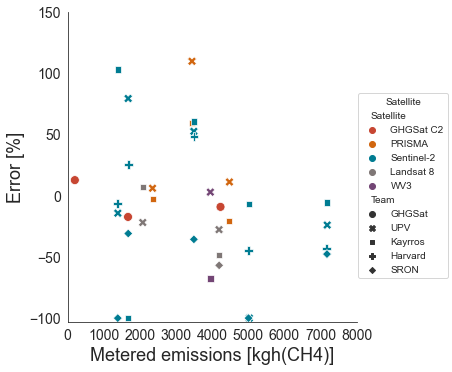

In [86]:
fig = plt.gcf()

unblindingStage = 1 # 2
sns.set_palette(sns.color_palette(StanfordPalette)) # colors
selectedSatelliteResults = satelliteResults[satelliteResults['UnblindingStage']==unblindingStage]
# Percent change
pctScatterPlot = sns.relplot(data=selectedSatelliteResults, x='cr_kgh_CH4_mean300', y='Error num', style='Team', hue='Satellite', s=80, kind='scatter') #, legend=False)
# In situ wind
# pctScatterPlot = sns.relplot(data=selectedSatelliteResults, x='cr_kgh_CH4_mean300', y='Error in situ wind num', style='Team', hue='Satellite', s=80, kind='scatter') #, legend=False)
# sns.move_legend(mainScatterPlot, 'upper left', bbox_to_anchor=(0.8, 0.99))
sns.set_style("white")
plt.xlim(0,8000)
plt.ylim(-103,150)
pctScatterPlot._legend.set_title("Satellite")
# mainScatterPlot._legend.draw_frame(True)
pctScatterPlot._legend.set_frame_on(True)
plt.xlabel('Metered emissions [kgh(CH4)]', fontsize=18)
plt.ylabel('Error [%]', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.rcParams["figure.figsize"] = (6,5)
# ax.get_yaxis().set_major_formatter(
#     ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
# ax.get_xaxis().set_major_formatter(
#     ticker.FuncFormatter(lambda x, p: format(int(x), ',')))# sns.set_style('darkgrid', {'legend.frameon':True})
plt.savefig('Satellite parity error 20220321.pdf', format='pdf')
# plt.savefig('Satellite parity error in situ wind 20220315b.pdf', format='pdf')
# plt.show()

In [137]:
unblindingStage = 1 # 2
# sns.set_palette(sns.color_palette(StanfordPalette)) # colors
selectedSatelliteResults = satelliteResults[satelliteResults['UnblindingStage']==unblindingStage]

# Fraction detected
totalPointsByTeamSat = selectedSatelliteResults.groupby('OperatorSet').size()
detectionAccuracy = pd.DataFrame(totalPointsByTeamSat, columns=['Total'])
detectionAccuracy['True positive'] =  selectedSatelliteResults.loc[selectedSatelliteResults['tc_Classification'] == 'TP'].groupby('OperatorSet').size()
detectionAccuracy['False negative'] = selectedSatelliteResults.loc[selectedSatelliteResults['tc_Classification'] == 'FN'].groupby('OperatorSet').size()
detectionAccuracy['True negative'] = selectedSatelliteResults.loc[selectedSatelliteResults['tc_Classification'] == 'TN'].groupby('OperatorSet').size()
detectionAccuracy['False positive'] = selectedSatelliteResults.loc[selectedSatelliteResults['tc_Classification'] == 'FP'].groupby('OperatorSet').size()
detectionAccuracy['Failed retrieval'] = selectedSatelliteResults.loc[selectedSatelliteResults['tc_Classification'] == 'FR'].groupby('OperatorSet').size()
detectionAccuracy['No measurement'] = selectedSatelliteResults.loc[selectedSatelliteResults['tc_Classification'] == 'NM'].groupby('OperatorSet').size()
detectionAccuracy.head()

,Total,True positive,False negative,True negative,False positive,Failed retrieval,No measurement
OperatorSet,,,,,,,
GHGSat C2/GHGSat,2,2,NaN,NaN,NaN,NaN,NaN
Landsat 8/Kayrros,2,2,NaN,NaN,NaN,NaN,NaN
Landsat 8/SRON,2,2,NaN,NaN,NaN,NaN,NaN
Landsat 8/UPV,2,2,NaN,NaN,NaN,NaN,NaN
PRISMA/Kayrros,2,2,NaN,NaN,NaN,NaN,NaN


In [136]:
selectedSatelliteResults.loc[selectedSatelliteResults['tc_Classification'] == 'TP'].groupby('OperatorSet').size()

OperatorSet
GHGSat C2/GHGSat      2
Landsat 8/Kayrros     2
Landsat 8/SRON        2
Landsat 8/UPV         2
PRISMA/Kayrros        2
PRISMA/UPV            2
Sentinel-2/Harvard    6
Sentinel-2/Kayrros    5
Sentinel-2/SRON       6
Sentinel-2/UPV        6
WV3/Kayrros           1
WV3/UPV               1
dtype: int64

In [ ]:
# selectedSatelliteResults.loc[selectedSatelliteResults['tc_Classification'] == 'TP']#.groupby('OperatorSet').size()
# selectedSatelliteResults.loc[selectedSatelliteResults['tc_Classification'] == 'TP'].groupby('OperatorSet').size()

#

detectionFraction = 100*pd.DataFrame(detectionAccuracy.drop(columns='Total').div(detectionAccuracy['Total'], axis='rows'))
detectionFraction[np.isnan(detectionFraction)] = 0
detectionFraction

['TruePositives',
 'TrueNegatives',
 'FalseNegatives',
 'FalsePositives',
 'FailedRetrieval',
 'NoMeasurement']

/Users/evansherwin/PycharmProjects/SatelliteTesting/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':


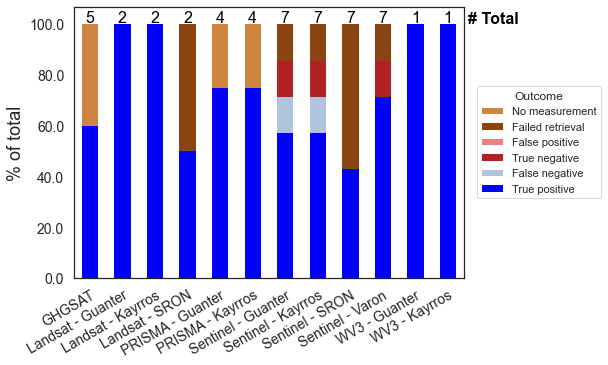

In [213]:
detectFracPlot = detectionFraction.plot(kind='bar', stacked=True, color=['blue', 'lightsteelblue', 'firebrick', 'lightcoral', 'saddlebrown', 'peru']) #, height=6) #, aspect=1.5)
for jj in np.arange(0, detectionAccuracy.iloc[:,0].size):
    detectFracPlot.text(jj-0.14, 100.6, detectionAccuracy.iloc[jj,0], fontsize=16, color='black', rotation='horizontal') # kgh
detectFracPlot.text(jj+0.6, 100.4, '# Total', fontsize=16, weight='bold', color='black', rotation='horizontal') # kgh
handles, labels = detectFracPlot.get_legend_handles_labels()
# detectFracPlot.add_legend(label_order = sorted(detectFracPlot._legend_data.keys(), key = int))
plt.legend(reversed(handles), reversed(labels), title='Outcome', bbox_to_anchor=(1.35, 0.5), loc='center right', borderaxespad=0)#, title_fontsize= 'large')
plt.ylim(0,107)
detectFracPlot.set(xlabel=None, ylabel='% of total')
plt.rcParams["axes.labelsize"] = 20
detectFracPlot.set_xticklabels(detectFracPlot.get_xticklabels(), fontsize=14, rotation=30, horizontalalignment='right', rotation_mode='anchor')
detectFracPlot.set_yticklabels(detectFracPlot.get_yticks(), size = 14)
plt.ylabel('% of total', size=18)
plt.setp(detectFracPlot.patches, linewidth=0)

# # Define some hatches
# hatches = ['', '', '\\', '\\', '', '', '']
#
# # Loop over the bars
# for i,thisbar in enumerate(detectFracPlot.patches):
#     # Set a different hatch for each bar
#     thisbar.set_hatch(hatches[i])

# plt.tick_params(axis='both', which='major', labelsize=14)
# detectFracPlot.set_ylabel('Fraction of total', fontsize=18)
# plt.rcParams["figure.figsize"] = (6,5)
# plt.figure(figsize=(6,5))
sns.set(rc={"figure.figsize":(7, 5)})
sns.set_style("white")
# plt.savefig('Detections 20220215.pdf', format='pdf', bbox_inches="tight")
plt.show()

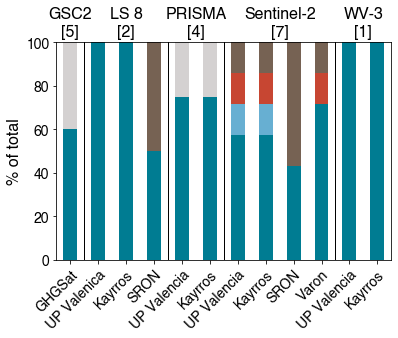

In [12]:
# Matplotlib version of detection plot
# Colors: https://identity.stanford.edu/design-elements/color/accent-colors/
# ['#007C92', '#67AFD2', '#C74632', '#F4795B', '#766253', '#D4D1D1']

fig, ax = plt.subplots()
#plt.font_manager._rebuild()
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'font.family':'Helvetica'})
# rc('font',**{'family':'serif','serif':['Helvetica']})
bar1 = ax.bar(detectionFraction.index, detectionFraction['True positive'], width=0.5, ec='None', color='#007C92')
bar2 = ax.bar(detectionFraction.index, detectionFraction['False negative'], bottom=detectionFraction['True positive'], ec='None', width=0.5, color='#67AFD2')
bar3 = ax.bar(detectionFraction.index, detectionFraction['True negative'], bottom=detectionFraction['True positive'] + detectionFraction['False negative'], ec='None', width=0.5, color='#C74632')
bar4 = ax.bar(detectionFraction.index, detectionFraction['False positive'], bottom=detectionFraction['True positive'] + detectionFraction['False negative'] + detectionFraction['True negative'], ec='None', width=0.5, color='#F4795B')
bar5 = ax.bar(detectionFraction.index, detectionFraction['Failed retrieval'], bottom=detectionFraction['True positive'] + detectionFraction['False negative'] + detectionFraction['True negative'] + detectionFraction['False positive'], ec='None', width=0.5, color='#766253')
bar6 = ax.bar(detectionFraction.index, detectionFraction['No measurement'], bottom=detectionFraction['True positive'] + detectionFraction['False negative'] + detectionFraction['True negative'] + detectionFraction['False positive'] + detectionFraction['Failed retrieval'], ec='None', width=0.5, color='#D4D1D1')
# for jj in np.arange(0, detectionAccuracy.iloc[:,0].size):
#     ax.text(jj-0.14, 100.6, detectionAccuracy.iloc[jj,0], fontsize=16, color='black', rotation='horizontal') # kgh
plt.ylabel('% of total', size=16)
# plt.xlabel('Team', size=16)
plt.xticks(np.arange(0, detectionAccuracy.iloc[:,0].size, 1), fontsize=14, rotation=90)
ax.set_xticklabels(['GHGSat', 'UP Valenica', 'Kayrros', 'SRON', 'UP Valencia', 'Kayrros', 'UP Valencia', 'Kayrros', 'SRON', 'Varon', 'UP Valencia', 'Kayrros'], rotation=45, rotation_mode='anchor', ha='right')
plt.text(0, 103, 'GSC2\n[5]', fontsize=16, color='black', rotation=0, ha='center') # -63
plt.text(2, 103, 'LS 8\n[2]', fontsize=16, color='black', rotation=0, ha='center') # -70
plt.text(4.5, 103, 'PRISMA\n[4]', fontsize=16, color='black', rotation=0, ha='center') # -64
plt.text(7.5, 103, 'Sentinel-2\n[7]', fontsize=16, color='black', rotation=0, ha='center') # -68
plt.text(10.5, 103, 'WV-3\n[1]', fontsize=16, color='black', rotation=0, ha='center') # -55
plt.axvline(0.5, ls='-', linewidth=1, color='black', ymin=-70)
plt.axvline(3.5, ls='-', linewidth=1, color='black', ymin=-70)
plt.axvline(5.5, ls='-', linewidth=1, color='black', ymin=-70)
plt.axvline(9.5, ls='-', linewidth=1, color='black', ymin=-70)
plt.yticks(np.arange(0, 101, 20), fontsize=14)
plt.ylim(0,100) # 107
plt.xlim(-0.5,11.5)
# plt.text(11+0.6, 100.4, '# Total', fontsize=18, color='black', rotation='horizontal') # kgh
# plt.text(-3, -20, 'Team', fontsize=20, color='black', rotation=0) # -55
# ax.legend(labels=detectionFraction.columns) # , handles=[bar1, bar2, bar3, bar4, bar5, bar6]
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles[::-1], labels[::-1], title='Line', loc='upper left')
# plt.rcParams['text.usetex'] = True # http://phyletica.org/matplotlib-fonts/
# plt.rcParams['ps.fonttype'] = 42
# plt.savefig('Detections 20220221f.pdf', format='pdf', bbox_inches="tight")
plt.show()

In [26]:
# Total estimates reported by all teams
# totalPointsAllTeams = (satelliteResults.loc[satelliteResults['Estimate (KGH)'] != 'Excise'].index).size
detectionAccuracyAllTeams = np.sum(detectionAccuracy)
detectionAccuracyAllTeams, detectionAccuracyAllTeams/detectionAccuracyAllTeams[0]
# satelliteResults.loc[satelliteResults['Estimate (KGH)'] != 'Excise'].size()

(Total               49.0
 True positive       32.0
 False negative       2.0
 True negative        3.0
 False positive       0.0
 Failed retrieval     8.0
 No measurement       4.0
 dtype: float64,
 Total               1.000000
 True positive       0.653061
 False negative      0.040816
 True negative       0.061224
 False positive      0.000000
 Failed retrieval    0.163265
 No measurement      0.081633
 dtype: float64)

In [43]:
# Error statistics, percent of detected emissions with Stage 1 absolute error below 50%
satelliteResults.loc[satelliteResults['Error num'] > -100, 'Error num'].describe()
detectedResults = satelliteResults.loc[satelliteResults['Error num'] > -100, 'Error num'].size
detectedResultsUnder50 = (abs(satelliteResults.loc[satelliteResults['Error num'] > -100, 'Error num']) < 50).sum()
detectedResultsUnder50, detectedResults, detectedResultsUnder50/detectedResults

(50, 64, 0.78125)

In [77]:
# Quantification error statistics
unblindingStage = 1 # 1 # 2
# sns.set_palette(sns.color_palette(StanfordPalette)) # colors
satelliteResults['Error num 60'] = (satelliteResults['Estimate (KGH) num'] - satelliteResults['cr_kgh_CH4_mean60'])*100/satelliteResults['cr_kgh_CH4_mean60']
satelliteResults['Error num 600'] = (satelliteResults['Estimate (KGH) num'] - satelliteResults['cr_kgh_CH4_mean600'])*100/satelliteResults['cr_kgh_CH4_mean600']
selectedSatelliteErr = (satelliteResults.loc[(satelliteResults['UnblindingStage']==unblindingStage) & (satelliteResults['Error num'] > -100), ['Error num', 'Error num 60', 'Error num 600']])
selectedSatelliteErr.describe()
# satelliteResults.loc[satelliteResults['Error num'] > -100, 'Error num'].describe()

,Error num,Error num 60,Error num 600
count,32.000000,32.000000,32.000000
mean,1.559186,1.535675,2.043903
std,45.370588,45.878814,44.913125
min,-67.603800,-67.469260,-68.111443
25%,-28.515522,-27.909010,-29.020234
50%,-6.525853,-7.834774,-5.659249
75%,16.072128,16.617495,17.377628
max,110.167867,113.263117,108.180112


In [85]:
# Fraction estimates with CI overlapping parity line
CI_overlapping_parity = satelliteResults.loc[(satelliteResults['UnblindingStage']==unblindingStage) & (satelliteResults['Error num'] > -100), 'within CI']==True
np.sum(CI_overlapping_parity)/CI_overlapping_parity.size

0.90625

In [12]:
# Number of errors between ±50%
np.mean(np.abs(selectedSatelliteErr) < 50)

0.75

In [45]:
# Wind error statistics
unblindingStage = 1 # 1 # 2
# sns.set_palette(sns.color_palette(StanfordPalette)) # colors
selectedWindErrPct = 100*(satelliteResults.loc[(satelliteResults['UnblindingStage']==unblindingStage)  & (satelliteResults['Error num'] > -100),'Wind speed est num'] - satelliteResults.loc[(satelliteResults['UnblindingStage']==unblindingStage) & (satelliteResults['Error num'] > -100), 'Wind_MPS_mean60'])/\
                     satelliteResults.loc[(satelliteResults['UnblindingStage']==unblindingStage) & (satelliteResults['Error num'] > -100), 'Wind_MPS_mean60']
selectedWindErrPct.describe()
# selectedWindErrPct

count    32.000000
mean    -19.180828
std      24.572177
min     -51.515152
25%     -38.559038
50%     -21.697465
75%      -3.102648
max      60.353884
dtype: float64

In [32]:
satelliteResults[['OperatorSet', 'Wind speed est num', 'Wind_MPS_mean30', 'Wind_MPS_mean60', 'Wind_MPS_mean300']]

,OperatorSet,Wind speed est num,Wind_MPS_mean30,Wind_MPS_mean60,Wind_MPS_mean300
0,GHGSat C2/GHGSat,3.720000,4.886000,4.877500,4.329133
1,GHGSat C2/GHGSat,4.270000,4.886000,4.877500,4.329133
2,GHGSat C2/GHGSat,2.010000,1.713333,2.011667,2.641100
3,GHGSat C2/GHGSat,2.490000,1.713333,2.011667,2.641100
4,GHGSat C2/GHGSat,5.060000,5.641667,5.359500,4.816333
...,...,...,...,...,...
83,Sentinel-2/SRON,0.000000,4.524667,4.038333,3.690500
84,WV3/UPV,3.771273,4.337667,3.923500,4.182300
85,WV3/Kayrros,2.900000,4.337667,3.923500,4.182300
86,WV3/UPV,4.673417,4.337667,3.923500,4.182300


In [46]:
# GHGSat errors
selectedSatelliteErrGHGSat = (satelliteResults.loc[(satelliteResults['UnblindingStage']==unblindingStage) & (satelliteResults['Error num'] > -100) & (satelliteResults['Team'] == 'GHGSat'), 'Error num'])
selectedSatelliteErrGHGSat

0   -17.140810
2    -8.889579
4    12.992303
Name: Error num, dtype: float64

In [19]:
# % difference from stage 1 to stage 2
stage1Ests = np.array(satelliteResults.loc[(satelliteResults['UnblindingStage']==1), 'Estimate (KGH) num'])
stage2Ests = np.array(satelliteResults.loc[(satelliteResults['UnblindingStage']==2), 'Estimate (KGH) num'])
pctChange = (stage2Ests - stage1Ests)/stage1Ests
np.nanmean(pctChange), np.nanmedian(pctChange)
# stage2Ests

/Users/evansherwin/PycharmProjects/SatelliteTesting/venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


(0.20657953068232066, 0.17719341361513885)

In [105]:
# Global Methane Pledge
ngProduction = pd.read_excel('/Users/evansherwin/PycharmProjects/SatelliteTesting/Data/EIA gas by country-02-22-2022_09-05-13.xls', sheet_name="EIA gas by country-02-22-2022_0", skiprows=1)
GMPCountries = pd.read_excel('/Users/evansherwin/PycharmProjects/SatelliteTesting/Data/GMP countries 20220222.xls', sheet_name="Sheet1")
ngProduction['Country'] = ngProduction['Unnamed: 1'].str.strip()
# ngProduction
# GMPCountries
# ngProduction['Country'].values.tolist()
# ngProduction['Country'].isin(GMPCountries).describe()
GMPCountriesProd = ngProduction.loc[ngProduction['Country'].isin(GMPCountries.iloc[:,0]), ['Country', 2019]]
GMPCountriesProdTot = GMPCountriesProd[2019].sum()
WorldProd = ngProduction.loc[ngProduction['Country']=='World', 2019]
GMPCountriesProdFrac = GMPCountriesProdTot/WorldProd
GMPCountriesProdTot, GMPCountriesProdFrac

(70775.037626469,
 1    0.496253
 Name: 2019, dtype: object)

In [109]:
GMPCountriesProd[GMPCountriesProd['Country']=='Gambia, The'],GMPCountriesProd.index.size



(        Country 2019
 78  Gambia, The    0,
 104)